## Title, Authors, and Introduction


```
# Title: Demographic Dynamics: Exploring Immigration Trends and Their Impact on US Population Growth.

Authors
dmcfarland@csumb.edu (David McFarland)
jdorn@csumb.edu (John Dorn)
tbalaj@csumb.edu (Teodora Balaj)


Introduction:
Our group is focused on understanding demographic trends, particularly those related to immigration and their influence on population growth in
the United States.

Demographic changes are occurring at an unprecedented rate worldwide, and by examining these trends, we can uncover insights into the factors
driving such changes. For our project, we have decided to concentrate on U.S. immigration trends and how they impact the growth of the U.S.
population.

Specifically, our research will address the topic: "Demographic Dynamics:Exploring Immigration Trends and Their Impact on US Population Growth."

```
```


```

Dataset sources:

https://www.dhs.gov/ohss/topics/immigration/yearbook/2022
Lawful Permanent Residents 2022 Data Tables (Including Supplementary Tables)
XLXS format
Table 1 provides year by year number of green card immigrants

https://www.census.gov/data/tables/time-series/dec/popchange-data-text.html
Historical Apportionment Data CSV file
CSV format
Table provides population of United States for every census year

https://data.worldbank.org/indicator/NY.GDP.MKTP.CD
Historical US GDP data
Table provides historic GDP data

We aim to predict future US population growth based on historic and recent immigration data.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk')


In [15]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [18]:
df1 = pd.read_csv("/content/drive/MyDrive/CST-383/Group 3 Project/lawful_permanent_residents_fy2022 cleaned.csv")
df2 = pd.read_csv("/content/drive/MyDrive/CST-383/Group 3 Project/apportionment.csv")
df3 = pd.read_csv("/content/drive/MyDrive/CST-383/Group 3 Project/annual_gdp.csv", skiprows=4)

In [19]:
print(df1.info())
print(df1.describe())

print(df2.info())
print(df2.describe())

print(df3.info())
print(df3.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    203 non-null    object
 1   Number  203 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB
None
             Number
count  2.030000e+02
mean   4.357433e+05
std    3.650547e+05
min    6.354000e+03
25%    1.445745e+05
50%    3.267000e+05
75%    6.430665e+05
max    1.826595e+06
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 10 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Name                                                 684 non-null    object 
 1   Geography Type                                       684 non-null    object 
 2   Year                                                 684 non-null    int64  
 3



# **Data Preperation**

Preperation of data for exploration and visualization. The data is clean of punctuation and non-numeric values are converted to numeric values

In [20]:
# clean and prepare the datasets
df1['Year'] = df1['Year'].astype(str).str.replace(' ', '', regex=False)
df1['Year'] = pd.to_numeric(df1['Year'], errors='coerce')
df1.dropna(subset=['Year'], inplace=True)

# Apportionment Data
df2['Resident Population'] = df2['Resident Population'].astype(str).str.replace(',', '', regex=False)
df2['Resident Population'] = pd.to_numeric(df2['Resident Population'])
df_agg_population = df2.groupby('Year')['Resident Population'].sum().reset_index(name='Population')
df_agg_population['Population_Change'] = df_agg_population['Population'].diff()

# GDP Data
us_gdp_df = df3[df3['Country Name'] == 'United States']
us_gdp_df = us_gdp_df.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1).T
us_gdp_df.columns = ['GDP']
us_gdp_df.index.name = 'Year'
us_gdp_df.reset_index(inplace=True)
us_gdp_df = us_gdp_df[us_gdp_df['Year'].str.isdigit()]
us_gdp_df['Year'] = us_gdp_df['Year'].astype(int)
us_gdp_df['GDP'] = pd.to_numeric(us_gdp_df['GDP'], errors='coerce')

# Drop all NaN values in each dataset
df1.dropna(inplace=True)
df_agg_population.dropna(inplace=True)
us_gdp_df.dropna(inplace=True)

# Merged datasets
merged_df = pd.merge(df1, df_agg_population, on='Year', how='inner')
final_df = pd.merge(merged_df, us_gdp_df, on='Year', how='inner')
melted_df = final_df.melt(id_vars='Year', value_vars=['Population_Change', 'Number', 'GDP'], var_name='Variable', value_name='Value')


<ipython-input-20-de9088bba69f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_gdp_df['Year'] = us_gdp_df['Year'].astype(int)
<ipython-input-20-de9088bba69f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_gdp_df['GDP'] = pd.to_numeric(us_gdp_df['GDP'], errors='coerce')
<ipython-input-20-de9088bba69f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

# **Data Visualization**

The following compares US population change with immigration rates and GDP. The data needed to be scaled in order to be useful since the US population is so large overall, it dwarves immigration numbers.



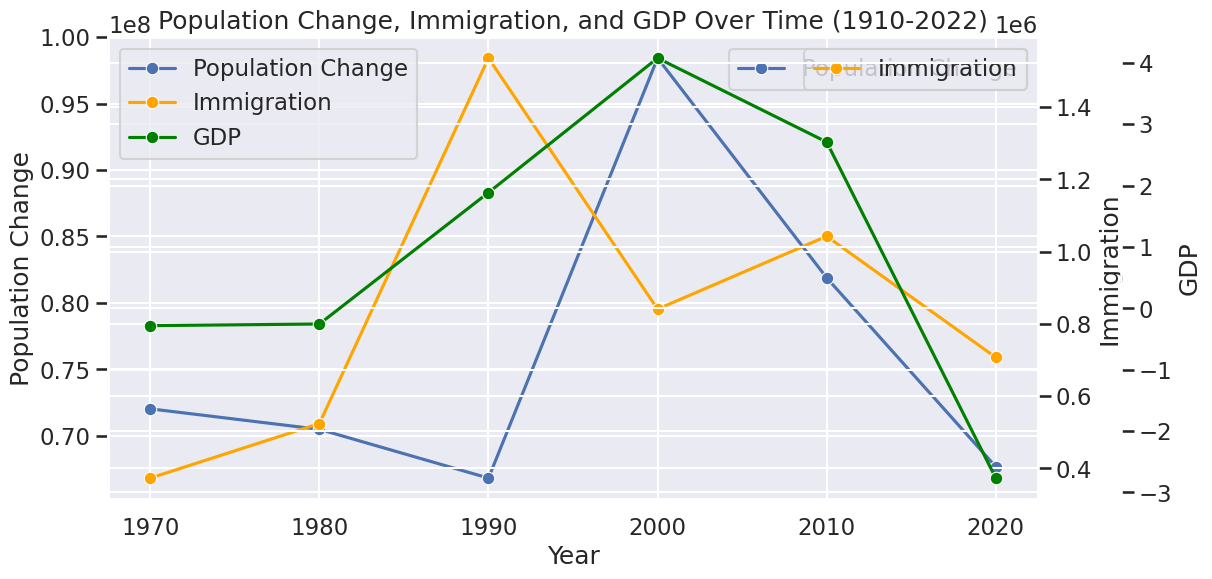

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

# Plot 'Population_Change' data
sns.lineplot(data=melted_df[melted_df['Variable'] == 'Population_Change'], x='Year', y='Value', marker='o', ax=ax1, label='Population Change')

# Plot Number (immigration) data
sns.lineplot(data=melted_df[melted_df['Variable'] == 'Number'], x='Year', y='Value', marker='o', ax=ax2, color='orange', label='Immigration')

# Plot GDPdata
sns.lineplot(data=melted_df[melted_df['Variable'] == 'GDP'], x='Year', y='Value', marker='o', ax=ax3, color='green', label='GDP')

ax1.set_ylabel('Population Change')
ax2.set_ylabel('Immigration')
ax3.set_ylabel('GDP')

plt.title('Population Change, Immigration, and GDP Over Time (1910-2022)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)
plt.show()

This graph seems to imply that there is a relationship between immigration and population growth in the US.

# **Machine Learning**

The following is an improved version of the linear regression model that was originally used and two other models that were added, since the addition of more features caused there to be a complex relationship that lead to overfitting. Working on the other models made the issues more apparent and much research was needed in order to tune properly. The addition of GDP proved to be challenging in particular since the relationship between GDP and immigration is not immediately obvious, but after much tuning, their appears to be a relationship between GDP growth and immigration, as well as population growth in general.

In [22]:
# Merge the datasets
merged_df = pd.merge(df1, df_agg_population, on='Year', how='inner')
final_df = pd.merge(merged_df, us_gdp_df, on='Year', how='inner')

# Adding lagged features
final_df['Lagged_Immigration'] = final_df['Number'].shift(1)
final_df['Lagged_Population_Change'] = final_df['Population_Change'].shift(1)
final_df['Lagged_GDP'] = final_df['GDP'].shift(1)

# Drop rows with NaN values
final_df.dropna(inplace=True)

# Features for the model
X = final_df[['Population_Change', 'GDP', 'Lagged_Immigration', 'Lagged_Population_Change', 'Lagged_GDP']].values
y = final_df['Number'].values

# Standardized features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Random Forest Model




In [23]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

regr_rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=regr_rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_scaled, y)
best_params_rf = grid_search_rf.best_params_
best_regr_rf = grid_search_rf.best_estimator_

# Evaluate the Random Forest model using cross-validation
cv_scores_rf = cross_val_score(best_regr_rf, X_scaled, y, cv=5)
print("Random Forest Cross-validation scores:", cv_scores_rf)
print("Random Forest Mean cross-validation score:", cv_scores_rf.mean())

# best Random Forest model
y_pred_rf = best_regr_rf.predict(X_scaled)

# Calculate mean squared error for Random Forest
mse_rf = mean_squared_error(y, y_pred_rf)
print("Random Forest Mean Squared Error:", mse_rf)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning

Random Forest Cross-validation scores: [nan nan nan nan nan]
Random Forest Mean cross-validation score: nan
Random Forest Mean Squared Error: 31137443161.385963


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# Gradient Boosting Model

In [24]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

regr_gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(estimator=regr_gb, param_grid=param_grid_gb, cv=5, n_jobs=-1, verbose=2)
grid_search_gb.fit(X_scaled, y)

# Best parameters and model for Gradient Boosting
best_params_gb = grid_search_gb.best_params_
best_regr_gb = grid_search_gb.best_estimator_

# Evaluate the Gradient Boosting model using cross-validation
cv_scores_gb = cross_val_score(best_regr_gb, X_scaled, y, cv=5)
print("Gradient Boosting Cross-validation scores:", cv_scores_gb)
print("Gradient Boosting Mean cross-validation score:", cv_scores_gb.mean())

# Predict using the best Gradient Boosting model
y_pred_gb = best_regr_gb.predict(X_scaled)

# Calculate mean squared error for Gradient Boosting
mse_gb = mean_squared_error(y, y_pred_gb)
print("Gradient Boosting Mean Squared Error:", mse_gb)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Gradient Boosting Cross-validation scores: [nan nan nan nan nan]
Gradient Boosting Mean cross-validation score: nan
Gradient Boosting Mean Squared Error: 16127130081.40245


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# Linear Regression Model

In [25]:

regr_lr = LinearRegression()
cv_scores_lr = cross_val_score(regr_lr, X_scaled, y, cv=5)
print("Linear Regression Cross-validation scores:", cv_scores_lr)
print("Linear Regression Mean cross-validation score:", cv_scores_lr.mean())

# Train and predict using Linear Regression
regr_lr.fit(X_scaled, y)
y_pred_lr = regr_lr.predict(X_scaled)

# Calculate mean squared error for Linear Regression
mse_lr = mean_squared_error(y, y_pred_lr)
print("Linear Regression Mean Squared Error:", mse_lr)

Linear Regression Cross-validation scores: [nan nan nan nan nan]
Linear Regression Mean cross-validation score: nan
Linear Regression Mean Squared Error: 8.348356728138384e-19


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Undefined

# Model Visualizations

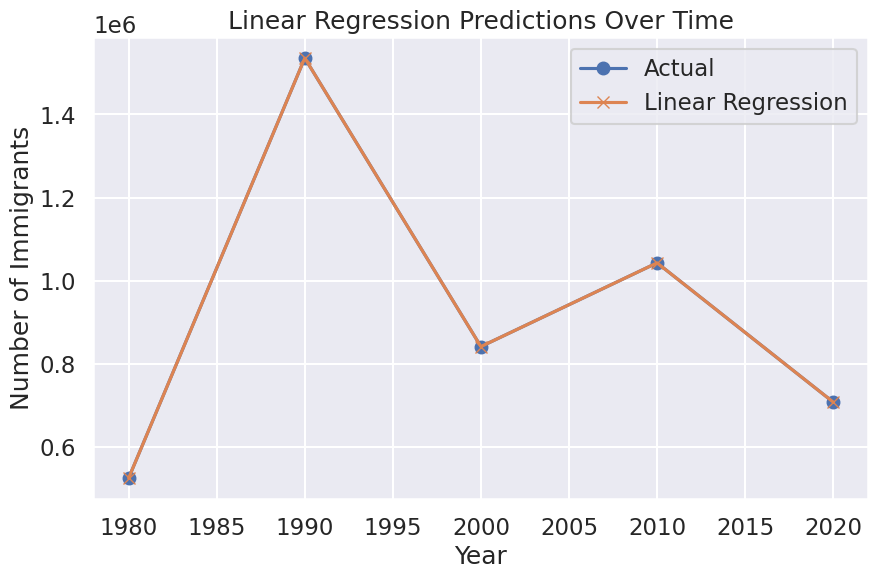

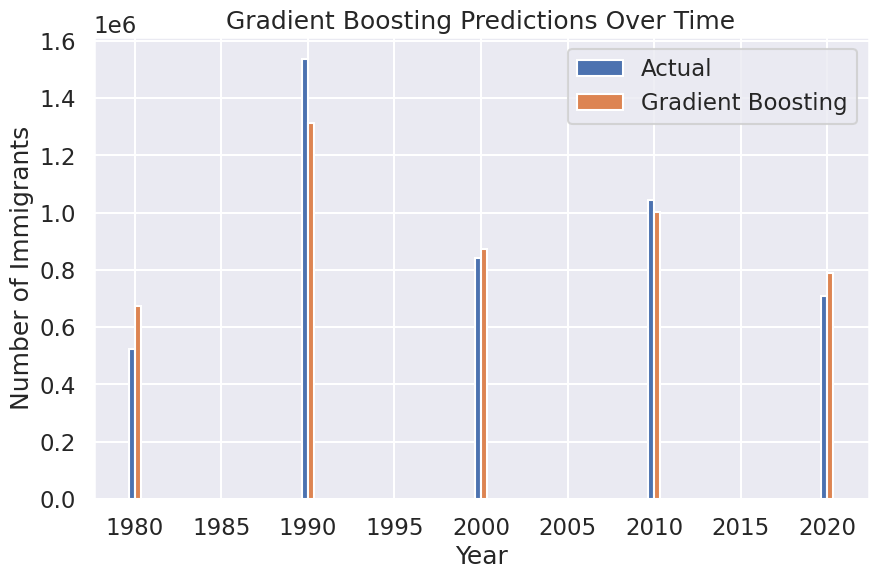

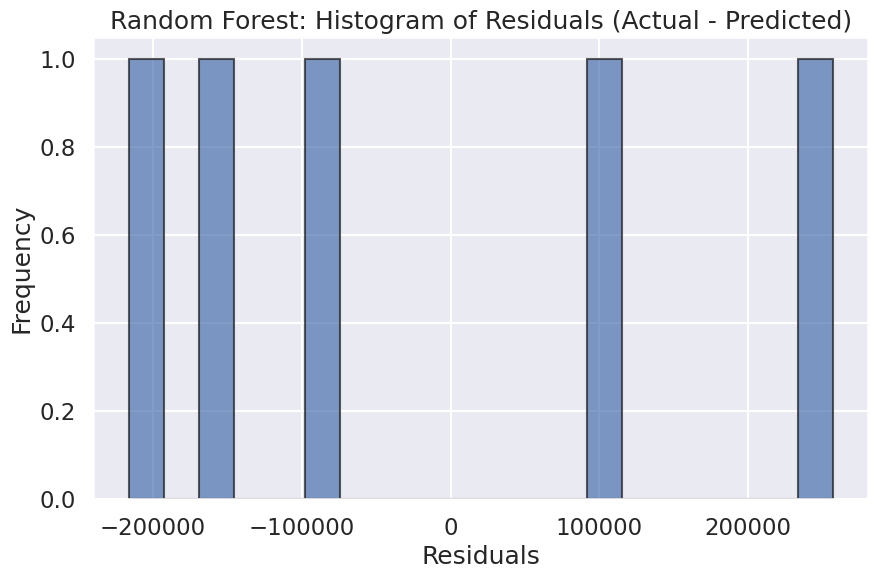

In [26]:
# Plot predictions for Linear Regression as a line graph
plt.figure(figsize=(10, 6))
plt.plot(final_df['Year'], y, label='Actual', marker='o')
plt.plot(final_df['Year'], y_pred_lr, label='Linear Regression', linestyle='-', marker='x')
plt.xlabel('Year')
plt.ylabel('Number of Immigrants')
plt.title('Linear Regression Predictions Over Time')
plt.legend()
plt.show()

# Plot predictions for Gradient Boosting as a bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
bar1 = plt.bar(final_df['Year'] - bar_width/2, y, bar_width, label='Actual')
bar2 = plt.bar(final_df['Year'] + bar_width/2, y_pred_gb, bar_width, label='Gradient Boosting')
plt.xlabel('Year')
plt.ylabel('Number of Immigrants')
plt.title('Gradient Boosting Predictions Over Time')
plt.legend()
plt.show()

# Plot histogram of residuals for Random Forest (differences between actual and predicted values)
residuals_rf = y - y_pred_rf
plt.figure(figsize=(10, 6))
plt.hist(residuals_rf, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Random Forest: Histogram of Residuals (Actual - Predicted)')
plt.show()